In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nltk

In [2]:
data = pd.read_csv('data/train.csv')

In [3]:
data.shape

(7613, 5)

In [4]:
data['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [5]:
data.drop_duplicates(subset=['text'], inplace=True ,keep = False, ignore_index=True)

In [6]:
data.shape

(7434, 5)

In [7]:
exemple = data.text[40]
exemple

"on the outside you're ablaze and alive\nbut you're dead inside"

In [8]:
tokens = nltk.word_tokenize(exemple)
tokens[:5]

['on', 'the', 'outside', 'you', "'re"]

In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:5]

[('on', 'IN'),
 ('the', 'DT'),
 ('outside', 'NN'),
 ('you', 'PRP'),
 ("'re", 'VBP')]

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [11]:
sia = SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores(exemple)

{'neg': 0.355, 'neu': 0.537, 'pos': 0.107, 'compound': -0.7311}

In [13]:
data.text[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [14]:
results = {}

for i in range(data.shape[0]):
    text = data.text[i]
    myid = data.id[i]
    results[myid] = sia.polarity_scores(text)

In [15]:
vaders = pd.DataFrame(results).T
vaders.reset_index(inplace = True, drop = True)

In [16]:
vaders

,neg,neu,pos,compound
0,0.000,0.851,0.149,0.2732
1,0.286,0.714,0.000,-0.3400
2,0.095,0.905,0.000,-0.2960
3,0.000,1.000,0.000,0.0000
4,0.000,1.000,0.000,0.0000
...,...,...,...,...
7429,0.249,0.751,0.000,-0.6841
7430,0.122,0.878,0.000,-0.4939
7431,0.328,0.574,0.098,-0.7650
7432,0.262,0.738,0.000,-0.4939


In [17]:
vaders = vaders.join(data)

In [18]:
vaders.head(5)

,neg,neu,pos,compound,id,keyword,location,text,target
0,0.000,0.851,0.149,0.2732,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,0.286,0.714,0.000,-0.3400,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,0.095,0.905,0.000,-0.2960,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,0.000,1.000,0.000,0.0000,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,0.000,1.000,0.000,0.0000,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
sorted_vaders = vaders.sort_values('compound').reset_index(drop = True)

In [20]:
sorted_vaders['compound'].isna().value_counts()

False    7434
Name: compound, dtype: int64

In [21]:
sorted_vaders.target[sorted_vaders['compound'] < 2].value_counts(normalize=True)

0    0.576271
1    0.423729
Name: target, dtype: float64

Text(0.5, 1.0, 'Compound negative')

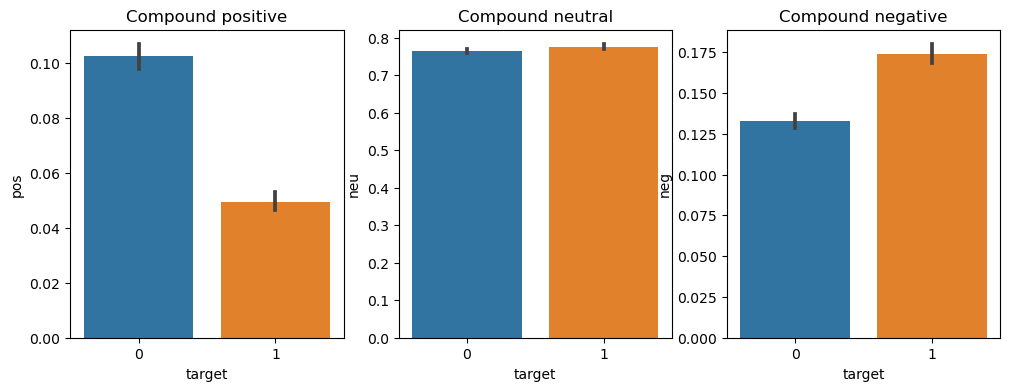

In [33]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
sns.barplot(data = sorted_vaders, x = 'target', y = 'pos', ax = axs[0])
sns.barplot(data = sorted_vaders, x = 'target', y = 'neu', ax = axs[1])
sns.barplot(data = sorted_vaders, x = 'target', y = 'neg', ax = axs[2])
axs[0].set_title('Compound positive')
axs[1].set_title('Compound neutral')
axs[2].set_title('Compound negative')

## ROBERTA Pretrained Model

In [36]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [37]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

2023-04-22 12:45:14.077116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-04-22 12:48:47.007458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [55]:
def polarity_scores_roberta(exemple):
    encoded_text = tokenizer(exemple, return_tensors='tf')
    output = model(**encoded_text)
    scores = output[0][0].numpy()
    scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2],
    }
    
    return scores_dict

In [ ]:
results = {}

for i in range(data.shape[0]):
    text = data.text[i]
    myid = data.id[i]
    vader_results = sia.polarity_scores(text)
    roberta_results = polarity_scores_roberta(text)
    both = [vader_results, roberta_results]
    results[myid] = both

In [64]:
vader_results

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [65]:
roberta_results

{'roberta_neg': 0.77916574,
 'roberta_neu': 1.1266321,
 'roberta_pos': -2.0468843}